# RNAseq analysis of microglial cells
> Goncalo Rodrigues _et al._ (2018)


# METHODS
### RNASeq Quality check and alignment
RNASeq fastq files were analyzed with FastQC[1] v0.11.7 to assess sequence base quality, per-base sequence content, GC content, N content, and the sequence length distribution. Reads were subsequently trimmed using Trimmomatic[2] v0.38, to remove Illumina adapters, leading and trailing bases with score ≤ 3, all bases after the sliding window average ≤ 15, and all edited reads ≤ 36 bp.
Reads were aligned to _Mus musculus_ annotation GRCm38.p6 using Salmon[3] v0.10.0. Default parameters were used for building the index and for alignment.


### Differential expression analysis
DESeq2[4] v1.18.1 was used to assess differential gene expression using the likelihood ratio test, with the model `~ replicate + condition` analyzed against the reduced model `~ replicate`. Variance Stabilized Transformed gene counts were used to identify outliers, using both Principal Component Analysis and sample clustering (using the euclidean distance metric and the complete clustering method). Two samples - wildtype replicate C and PBS replicate C - were removed from further analysis.

To identify significant contrasts between treatments, a _post hoc_ analysis of genes differentially expressed according to LRT analysis was performed. DESeq2 was used to perform the nbinomial Wald test for contrasts between PBS, WT, KO1 and KO2. 

The focal gene set was identified as those genes in which:
* the likelihood ratio test was significant (*p* ≤ 0.05)
* WT and PBS were significantly differentially expressed (*p* ≤ 0.05)
* WT was significantly different from both KO1 and KO2 (*p* ≤ 0.05 in each contrast)
* KO1 and KO2 were concordantly up- or down- regulated with regard to WT

Log2(Fold change) values and _p_ values are reported according to the Wald tests.

Gene names were mapped to entrez gene identifiers using ensembl biomart[5], mouse version GRCm38.p6.

All scripts and output of the differential analysis are available at doi: <available on publication>. The R Script used for differential expression analysis can be found in supplementary file differential-expression-analysis.R The python script used for subsequent post hoc analysis can be found in the Jupyter notebooks endothelial_expression_analysis.ipynb and microglial_expression_analysis.ipynb.


### Bibliography
1. Andrews, S. FastQC: a quality control tool for high throughput sequence data. (2010). at <http://www.bioinformatics.babraham.ac.uk/projects/fastqc>
2. Bolger, A. M., Lohse, M. & Usadel, B. Trimmomatic: a flexible trimmer for Illumina sequence data. Bioinformatics 30, 2114–2120 (2014).
3. Patro, R., Duggal, G., Love, M. I., Irizarry, R. A. & Kingsford, C. Salmon provides fast and bias-aware quantification of transcript expression. Nat. Methods 14, 417–419 (2017).
4. Love, M. I., Huber, W. & Anders, S. Moderated estimation of fold change and  dispersion for RNA-seq data with DESeq2. Genome Biol. 15, 550 (2014).
5. Zerbino, D. R. et al. Ensembl 2018. Nucleic Acids Res. 46, D754–D761 (2018).


# NOTEBOOK ANALYSIS

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
from scipy.spatial.distance import pdist, squareform, warnings

In [4]:
warnings.simplefilter('ignore',)

In [5]:
import re

## Load Data
this includes the DESeq2 LRT analysis results, and the variance stabilized transformed (VST) expression values

In [6]:
df_mg = pd.read_csv("../DESeq2_R-project/res_mg-results.csv", sep=',')

In [7]:
df_mg.head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,11287,1.934590,-0.593551,4.247045,1.276578,0.734702,NaN
1,11298,0.316304,2.098142,4.211749,0.641457,0.886880,NaN
2,11302,12.814439,-3.345539,3.946821,2.067634,0.558488,NaN
3,11303,2981.665707,0.299286,0.285279,3.675644,0.298686,0.903654
4,11304,0.000000,NaN,NaN,NaN,NaN,NaN


NB: NaN values arise when the LRT statistic cannot be calculated (if all values are 0), or when the gene is filtered due to low basemean and high variance (padj only)

In [8]:
# view the number of differentially expressed genes:
df_mg[df_mg.padj <= 0.05].shape[0]

238

**Load the gene name table**

This table allows conversion between isoform, gene, uniprot gene id and ncbi gene name.

In [9]:
df_names = pd.read_csv("../scripts/transcript-name-conversion.csv")

# convert entrez geneid to integer
df_names['entrezgene'] = df_names.entrezgene.apply(lambda x: 0 if pd.isnull(x) else int(x))
df_names.head()

,refseq_mrna,entrezgene,uniprot_gn,external_gene_name
1,NM_001001130,22746,Q7TMC9,Zfp85
2,NM_001001144,235623,Q6GQT6,Scap
3,NM_001001152,238690,Q7M6X6,Zfp458
4,NM_001001152,238690,Q6P5C7,Zfp458
5,NM_001001160,330369,Q6NS60,Fbxo41


**Load the expression data**

In [10]:
df_mg_exp = pd.read_csv("../DESeq2_R-project/counts-mg-vst.csv", 
                        delim_whitespace=True
                       )

In [11]:
df_mg_merge = pd.merge(left=df_mg, right=df_names.iloc[:, 1:], 
                        left_on="Unnamed: 0", right_on="entrezgene",
                        how="left")

In [12]:
df_mg_merge[df_mg_merge.padj <= 0.05].to_csv("MG_LRT_DEGs.csv")

In [13]:
deg_gene_names = df_mg_merge[df_mg_merge.padj <= 0.05
                            ].sort_values("padj"
                            ).external_gene_name.unique()
print(len(deg_gene_names), "differentially expressed genes:")
print(",".join(deg_gene_names))

238 differentially expressed genes:
Acod1,Ccl5,Ifit1,Ccl2,Cxcl2,Cxcl1,Usp18,Sod2,Cxcl3,Irgm2,Lgals3bp,Map3k2,Ccrl2,Ptgs2,Fcgr1,Ifitm3,Cxcl10,Cybb,Bst2,Tnfrsf1b,Gbp9,Rtp4,Siglec1,Stat2,Zbp1,Wdr35,Tnf,Gsap,Slc31a2,Il1b,Mfsd8,Mfap3l,B2m,Ifit3b,Sbno1,Syk,Ints14,H2-Q4,Grap,Smug1,Atp10a,Pros1,Ctsc,Rnaset2b,Rsad2,Skiv2l2,Mgat4a,Ifi209,Tsc1,Rsbn1,Chchd10,Plau,F2r,Uba7,Irgm1,Poc5,Glrx,Tmem87a,Tlr2,Kctd12,Tnfaip3,Laptm5,Sp100,Ttll4,Aldh18a1,Mdm4,Gabpb2,Flna,Ifi27l2a,Zc3hav1,Ifnb1,Tjp2,Phf11d,Rab43,Siglech,Milr1,Mfsd9,Wars,Clec4e,Parp14,Atp6v0d2,Ifi205,Heatr3,Irf9,Zcwpw1,Nrp2,Pla2g7,Itgb1bp1,Virma,Shisa5,Cd53,Ipo13,Wdr92,Cdk5rap2,Nkiras2,Parp12,H2-T24,Mif,Psen1,Zfp646,Gzf1,Rab11fip1,Utp20,Zdhhc7,Pcdhgc3,Zfp248,Atf7,Echs1,Map2k3,Trp53inp2,Lilr4b,Slfn2,Ndst2,Gng2,Pld4,Ier3,Trex1,Slfn1,Traf3ip1,Aldh2,Abcf3,Mmp14,Iqgap1,Synj2bp,Ap3d1,Lta4h,Tpcn2,Ifit3,H2-T23,Sgk1,Rab3gap2,Adar,3830406C13Rik,Pim1,Sart3,Plpp3,Tmem147,Rhob,Flvcr2,Smpd4,U2surp,Pkn2,Fam134b,Ampd2,Spp1,Pole2,Sfxn1,Capzb,Plagl2,Ms4a7,Fbxo11

In [14]:
deg_gene_names = df_mg_merge[df_mg_merge.padj <= 0.05
                            ].sort_values("padj").entrezgene.unique()
print(len(deg_gene_names), "differentially expressed genes (entrez id):")
print(",".join([str(i) for i in deg_gene_names]))

238 differentially expressed genes (entrez id):
16365,20304,15957,20296,20310,14825,24110,20656,330122,54396,19039,26405,54199,19225,14129,66141,15945,13058,69550,21938,236573,67775,20612,20847,58203,74682,21926,212167,20530,16176,72175,71306,12010,667370,243272,20963,69882,15015,71520,71726,11982,19128,13032,68195,58185,72198,269181,236312,64930,229675,103172,18792,14062,74153,15944,67463,93692,211499,24088,239217,21929,16792,20684,67534,56454,17248,213054,192176,76933,78781,15977,21873,219132,69834,233274,380732,211798,22375,56619,547253,242341,226695,234549,16391,381678,18187,27226,16413,66185,66940,12508,230673,103784,214444,71966,243771,15042,17319,19164,233905,74533,75767,70683,102193,93706,72720,223922,93747,26397,68728,14727,20556,17423,14702,104759,15937,22040,20555,74019,11669,27406,17387,29875,24071,11776,16993,233979,15959,15040,20393,98732,56417,218734,18712,53890,67916,69804,11852,217721,77626,67958,109333,66270,109674,20750,18974,14057,12345,54711,109225,225055,13033,715

In [15]:
s_name_conversion = df_mg_merge.set_index("entrezgene").external_gene_name.drop_duplicates()

In [16]:
degs_mg = df_mg[df_mg.padj <= 0.05]["Unnamed: 0"].values

In [17]:
df_mg_degs_exp = df_mg_exp[df_mg_exp.index.isin(degs_mg)]

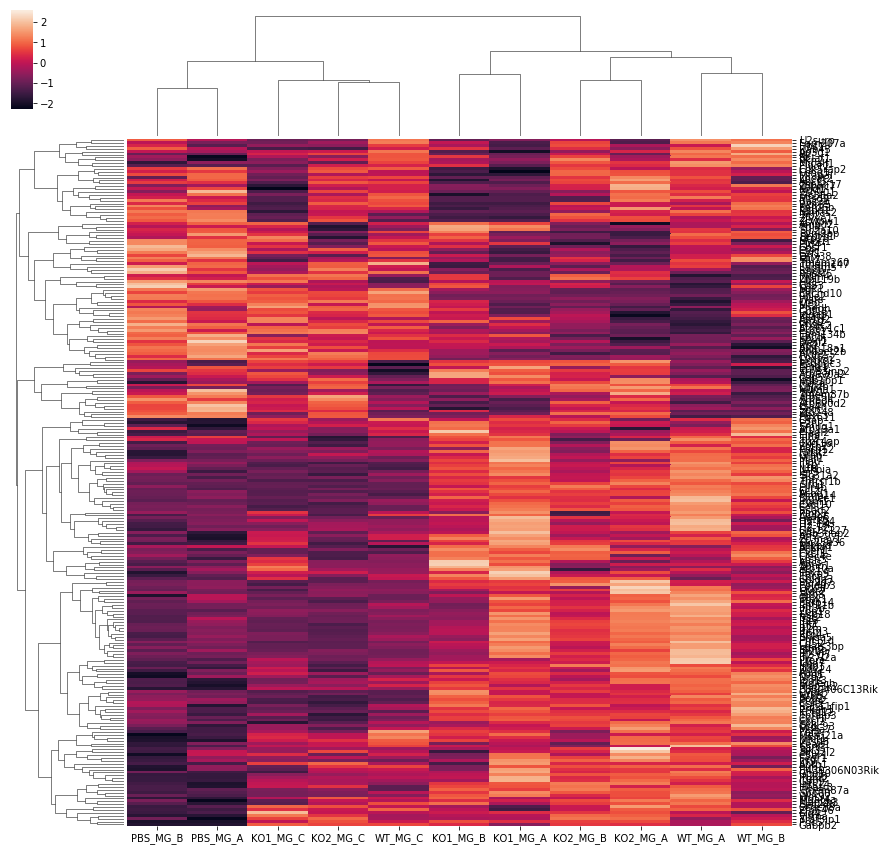

In [18]:
sns.clustermap(method='complete', metric='euclidean',
                data=df_mg_degs_exp, z_score=0, 
                yticklabels=[s_name_conversion.loc[idx] for idx in df_mg_degs_exp.index],
               figsize=(14,15)
              )
plt.show()

# _post hoc_ analysis of DEGs
This is to identify, from among the DEGs already found above with the LRT model, those contrasts for which there are significant differences between conditions

## load _post hoc_ data

In [19]:
# suffix indicates the contrast analysed
fp_pw = "../DESeq2_R-project/res_mg_wald_PW-results.csv"
fp_pk1 = "../DESeq2_R-project/res_mg_wald_PK1-results.csv"
fp_pk2 = "../DESeq2_R-project/res_mg_wald_PK2-results.csv"
fp_k1k2 = "../DESeq2_R-project/res_mg_wald_K1K2-results.csv"
fp_wk1 = "../DESeq2_R-project/res_mg_wald_WK1-results.csv"
fp_wk2 = "../DESeq2_R-project/res_mg_wald_WK2-results.csv"

In [20]:
# set header names
names_base = ["entrezgene", "baseMean", "log2FoldChange", 
              "lfcSE", "stat", "pvalue", "padj"]
conditions_base = ["pw", "pk1", "pk2", "k1k2", "wk1", "wk2"]
names_pw = [ "{}_pw".format(x) for x in names_base ]
names_pk1 = [ "{}_pk1".format(x) for x in names_base ]
names_pk2 = [ "{}_pk2".format(x) for x in names_base ]
names_k1k2 = [ "{}_k1k2".format(x) for x in names_base ]
names_wk1 = [ "{}_wk1".format(x) for x in names_base ]
names_wk2 = [ "{}_wk2".format(x) for x in names_base ]

In [21]:
# create dataframes
df_pw = pd.read_csv(fp_pw, header=0, names=names_pw).set_index("entrezgene_pw")
df_pk1 = pd.read_csv(fp_pk1, header=0, names=names_pk1).set_index("entrezgene_pk1")
df_pk2 = pd.read_csv(fp_pk2, header=0, names=names_pk2).set_index("entrezgene_pk2")
df_k1k2 = pd.read_csv(fp_k1k2, header=0, names=names_k1k2).set_index("entrezgene_k1k2")
df_wk1 = pd.read_csv(fp_wk1, header=0, names=names_wk1).set_index("entrezgene_wk1")
df_wk2 = pd.read_csv(fp_wk2, header=0, names=names_wk2).set_index("entrezgene_wk2")


In [22]:
# merge dataframes together:
df_posthoc = pd.concat([df_pw, df_pk1, df_pk2, df_k1k2, df_wk1, df_wk2], axis=1)

In [23]:
df_posthoc.head()

,baseMean_pw,log2FoldChange_pw,lfcSE_pw,stat_pw,pvalue_pw,padj_pw,baseMean_pk1,log2FoldChange_pk1,lfcSE_pk1,stat_pk1,...,lfcSE_wk1,stat_wk1,pvalue_wk1,padj_wk1,baseMean_wk2,log2FoldChange_wk2,lfcSE_wk2,stat_wk2,pvalue_wk2,padj_wk2
11287,1.934590,4.768127,4.697422,1.015052,0.310081,0.819093,1.934590,5.921332,4.697530,1.260520,...,4.247045,0.271531,7.859826e-01,9.992019e-01,1.934590,0.593551,4.247045,0.139756,0.888853,0.997184
11298,0.316304,-0.270229,4.903197,-0.055113,0.956049,0.998468,0.316304,-0.079014,4.903307,-0.016114,...,4.247045,0.045023,9.640890e-01,9.992019e-01,0.316304,-2.098142,4.211749,-0.498164,0.618368,0.997184
11302,12.814439,3.962726,4.484222,0.883704,0.376856,0.869637,12.814439,27.788118,4.570384,6.080040,...,4.026470,5.917191,3.274860e-09,4.912291e-07,12.814439,3.345539,3.946821,0.847654,0.396631,0.997184
11303,2981.665707,0.513416,0.329137,1.559885,0.118787,0.545990,2981.665707,0.535819,0.329112,1.628077,...,0.285218,0.078547,9.373928e-01,9.992019e-01,2981.665707,-0.299286,0.285279,-1.049098,0.294133,0.997184
11304,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


## Identify focal geneset
### create filters to identify each of the following subsets of genes:
* the likelihood ratio test was significant (*p* ≤ 0.05)
* WT and PBS were significantly differentially expressed (*p* ≤ 0.05)
* WT was significantly different from both KO1 and KO2 (*p* ≤ 0.05 in each contrast)
* KO1 and KO2 were concordantly up- or down- regulated with regard to WT


In [24]:
# significant in LRT test
mask_degs = df_posthoc.index.isin(degs_mg)

In [25]:
# remove non sig for PBS vs WT P>0.05
mask_pw_sig = (df_posthoc.pvalue_pw <= 0.05)

In [26]:
# change PBS/WT to WT/PBS, for clearer interpretation of direction of change
df_posthoc.loc[:, "log2FoldChange_wp"] = df_posthoc.loc[:, "log2FoldChange_pw"] * -1
df_posthoc.loc[:, "stat_wp"] = df_posthoc.loc[:, "stat_pw"] * -1

In [27]:
# Remove non significant in wt vs k1 and/or k2
mask_wk_sig = (df_posthoc.pvalue_wk1 <= 0.05) & (df_posthoc.pvalue_wk2 <= 0.05)

In [28]:
# tag significant in k1 vs k2
mask_k1k2_sig = (df_posthoc.pvalue_k1k2 <= 0.05)

In [29]:
# remove the ones changing significantly between WT/K1 and WT/K2 but in different senses
mask_concordant = ((df_posthoc.log2FoldChange_wk1 / df_posthoc.log2FoldChange_wk2) > 0) 

### combine filters to identify focal geneset

In [30]:
df_final = df_posthoc[mask_degs &
                      mask_pw_sig & 
                      mask_wk_sig &
                      mask_concordant
                     ]

In [31]:
df_final.shape

(25, 38)

### Print list of 25 focal genes

In [32]:
# get gene names:
final_list = pd.merge(left=df_final.reset_index(), 
                     right=df_names.drop_duplicates(subset=['entrezgene', 'external_gene_name']),
                     left_on='index', right_on='entrezgene',
                     how='inner'
                    )['external_gene_name'].values

In [33]:
print(",".join(final_list))

Cxcl1,Cxcl10,Acod1,Mdm4,Ptgs2,Ccl5,Syk,Tnf,Tnfrsf1b,Xk,Map3k2,Sart3,Ccrl2,Hbs1l,Aldh18a1,Trp53inp2,Bst2,Rab43,Bclaf1,Zfp248,Echs1,Fam207a,Fbxo11,Zfp119b,Parp14


## view correlation in expression differences between conditions

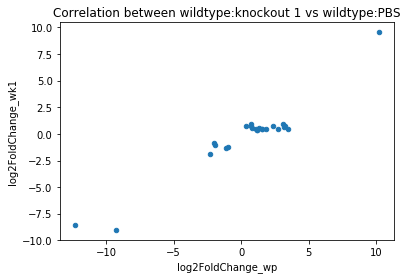

In [34]:
df_final.plot.scatter(x='log2FoldChange_wp',
                      y='log2FoldChange_wk1'
                     )
plt.title("Correlation between wildtype:knockout 1 vs wildtype:PBS")
plt.show()

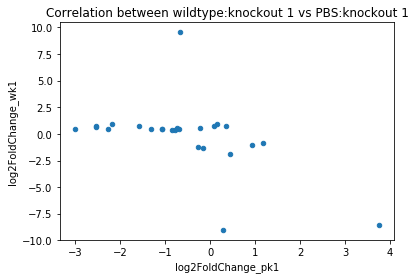

In [35]:
df_final.plot.scatter(x='log2FoldChange_pk1',
                      y='log2FoldChange_wk1'
                     )
plt.title("Correlation between wildtype:knockout 1 vs PBS:knockout 1")
plt.show()